In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Master/Randomization and Probabilistic Techniques/STS Covid 19'

/content/drive/MyDrive/Master/Randomization and Probabilistic Techniques/STS Covid 19


In [1]:
#@title Import
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14,7

import warnings
warnings.filterwarnings('ignore')

# Plotting setup
Helper methods for plotting time series and forecasts.

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [3]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [4]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [5]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

# Review data

In [6]:
df = pd.read_csv('covid_data_kerala.csv',index_col='Date',parse_dates=True)

In [7]:
df.index.freq='D'

In [8]:
df.index

DatetimeIndex(['2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08',
               ...
               '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21',
               '2021-10-22', '2021-10-23', '2021-10-24', '2021-10-25',
               '2021-10-26', '2021-10-27'],
              dtype='datetime64[ns]', name='Date', length=637, freq='D')

In [9]:
del df['Recovered']
del df['Deceased']

In [10]:
df.head()

,Confirmed
Date,
2020-01-30,NaN
2020-01-31,0.0
2020-02-01,0.0
2020-02-02,1.0
2020-02-03,1.0


In [11]:
df.tail()

,Confirmed
Date,
2021-10-23,8909.0
2021-10-24,8538.0
2021-10-25,6664.0
2021-10-26,7163.0
2021-10-27,9445.0


In [12]:
# shape of the dataframe
df.shape

(637, 1)

In [ ]:
# concise summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 637 entries, 2020-01-30 to 2021-10-27
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Confirmed  636 non-null    float64
dtypes: float64(1)
memory usage: 10.0 KB


In [ ]:
# checking for null values
df.isnull().sum()

Confirmed    1
dtype: int64

In [ ]:
# descriptive statistics of data
df.describe()

,Confirmed
count,636.000000
mean,7765.097484
std,9296.326197
min,0.000000
25%,293.750000
50%,4953.000000
75%,11601.250000
max,43529.000000


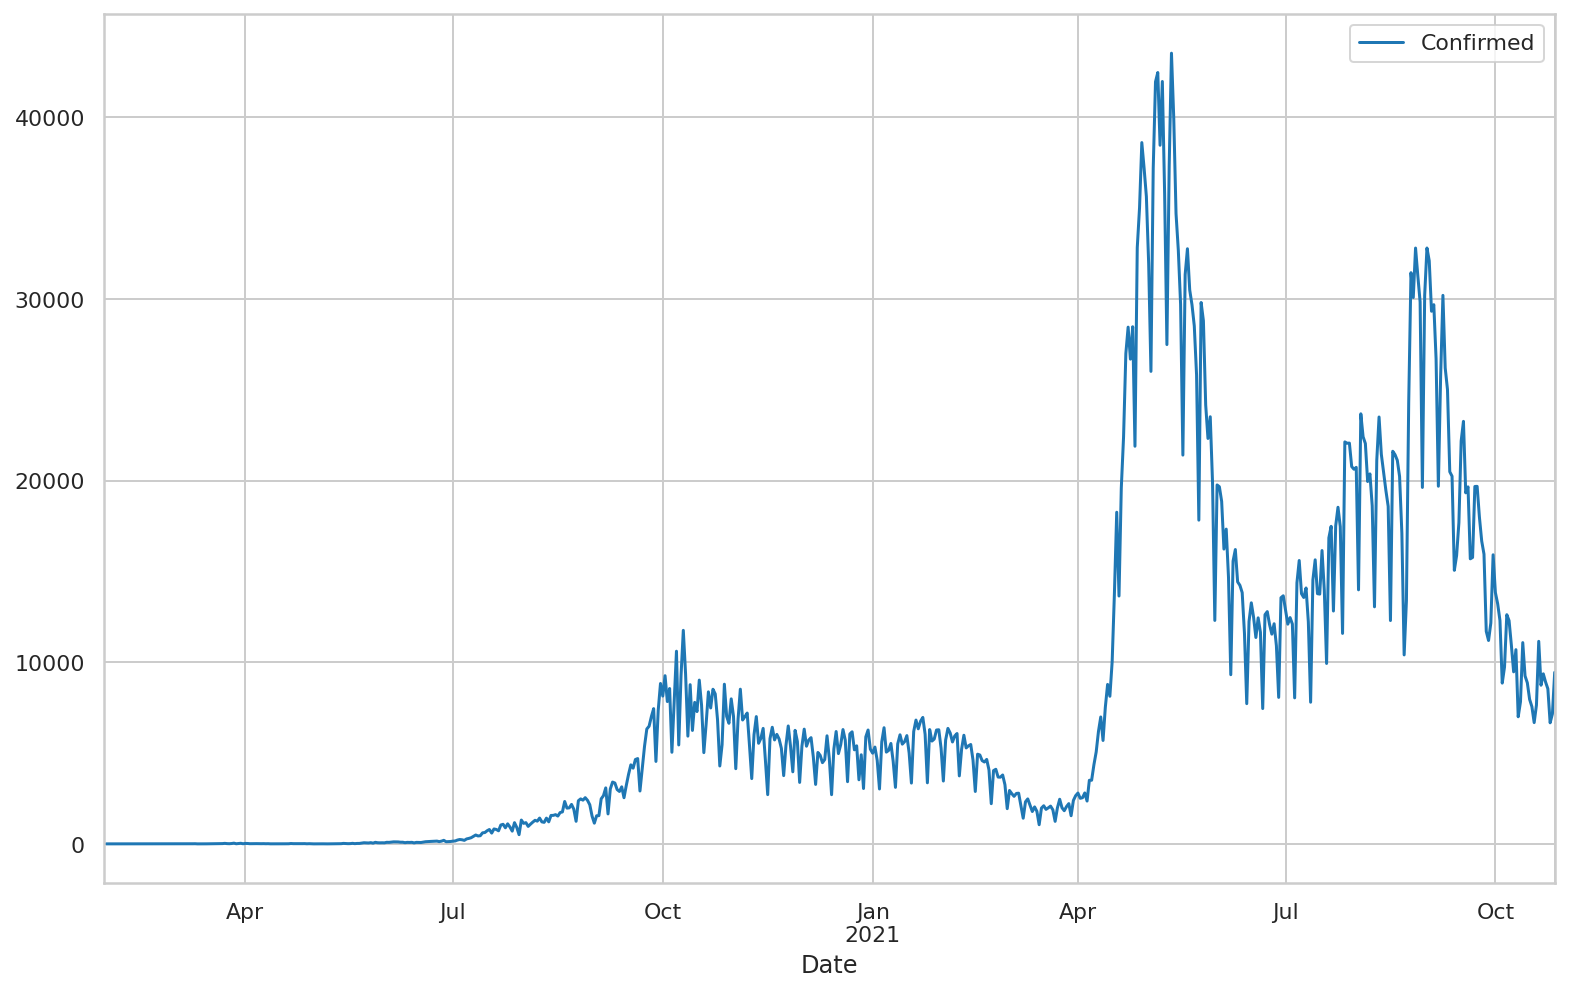

In [13]:
df.plot(figsize=(13,8))

# STS model

In [14]:
df=df.loc['2020-06-01':]
df.head

<bound method NDFrame.head of             Confirmed
Date                 
2020-06-01       57.0
2020-06-02       86.0
2020-06-03       82.0
2020-06-04       94.0
2020-06-05      111.0
...               ...
2021-10-23     8909.0
2021-10-24     8538.0
2021-10-25     6664.0
2021-10-26     7163.0
2021-10-27     9445.0

[514 rows x 1 columns]>

In [ ]:
from datetime import datetime
conf = df.index
conf

DatetimeIndex(['2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08',
               '2020-06-09', '2020-06-10',
               ...
               '2021-10-18', '2021-10-19', '2021-10-20', '2021-10-21',
               '2021-10-22', '2021-10-23', '2021-10-24', '2021-10-25',
               '2021-10-26', '2021-10-27'],
              dtype='datetime64[ns]', name='Date', length=514, freq='D')

In [ ]:
demand_dates = np.arange('2020-06-01', '2021-10-27', dtype='datetime64[h]')
demand_dates

array(['2020-06-01T00', '2020-06-01T01', '2020-06-01T02', ...,
       '2021-10-26T21', '2021-10-26T22', '2021-10-26T23'],
      dtype='datetime64[h]')

In [15]:
from datetime import timedelta
confirmed_loc = mdates.WeekdayLocator(byweekday=mdates.MO)
confirmed_fmt = mdates.DateFormatter('%a %b %d')

num_forecast_steps = 24 * 7 * 2 # Two weeks.
confirmed_training_data = df[:-num_forecast_steps]

In [19]:
def build_model(observed_time_series):
  #trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  
  week_of_month_effect = sts.Seasonal(
      num_seasons=4, #4 weeks in month
      num_steps_per_season=7, # 7 day in week
      observed_time_series=observed_time_series,
      name='week_of_month_effect')
  month_of_year_effect = sts.Seasonal(
      num_seasons=12, #1 year have 12 month
      num_steps_per_season=4, # 1 month have 4 week
      observed_time_series=observed_time_series,
      name='month_of_year_effect')
  autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
  model = sts.Sum([#trend, 
                   week_of_month_effect,
                   month_of_year_effect,
                   autoregressive], 
                  observed_time_series=observed_time_series)
  return model

In [20]:
def build_model(observed_time_series):
  trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
  seasonal = tfp.sts.Seasonal(
      num_seasons=12, observed_time_series=observed_time_series)
  
  model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
  return model

In [21]:
confirmed_model = build_model(confirmed_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
    model=confirmed_model)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


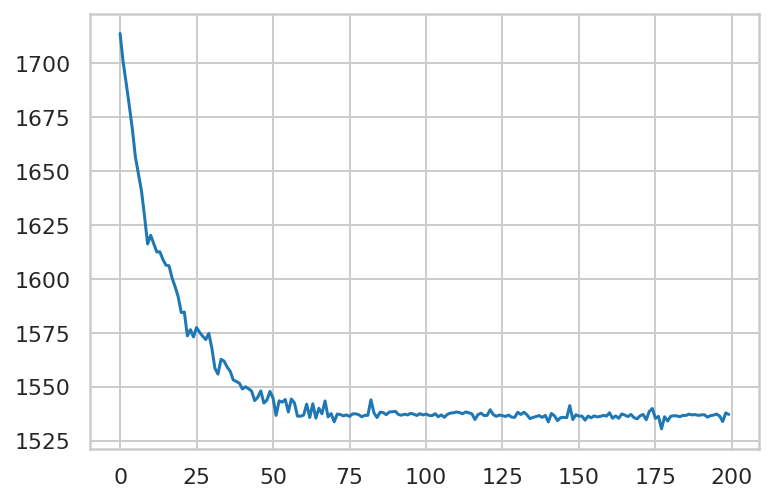

In [22]:
#@title Minimize the variational loss.
#Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200 # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=confirmed_model.joint_log_prob(
        observed_time_series=confirmed_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True)
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_confirmed_ = variational_posteriors.sample(50)

In [23]:
print("Inferred parameters:")
for param in confirmed_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_confirmed_[param.name], axis=0),
                              np.std(q_samples_confirmed_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 962.0466054130629 +- 51.22906678630256
LocalLinearTrend/_level_scale: 54.935070017871915 +- 54.04285575490839
LocalLinearTrend/_slope_scale: 32.85815509448104 +- 7.167092995440586
Seasonal/_drift_scale: 17.86742965836077 +- 32.82849929080688


In [24]:
confirmed_forecast_dist = tfp.sts.forecast(
    model=confirmed_model,
    observed_time_series=confirmed_training_data,
    parameter_samples=q_samples_confirmed_,
    num_steps_forecast=num_forecast_steps)

In [25]:
num_samples=10

(
    confirmed_forecast_mean,
    confirmed_forecast_scale,
    confirmed_forecast_samples
) = (
    confirmed_forecast_dist.mean().numpy()[..., 0],
    confirmed_forecast_dist.stddev().numpy()[..., 0],
    confirmed_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

In [26]:
a = np.arange('2020-06-01', '2021-10-28', dtype='datetime64[D]')
#a = df1['Date']
b = df['Confirmed']

In [27]:
print(a.shape)
print(b.shape)

(514,)
(514,)


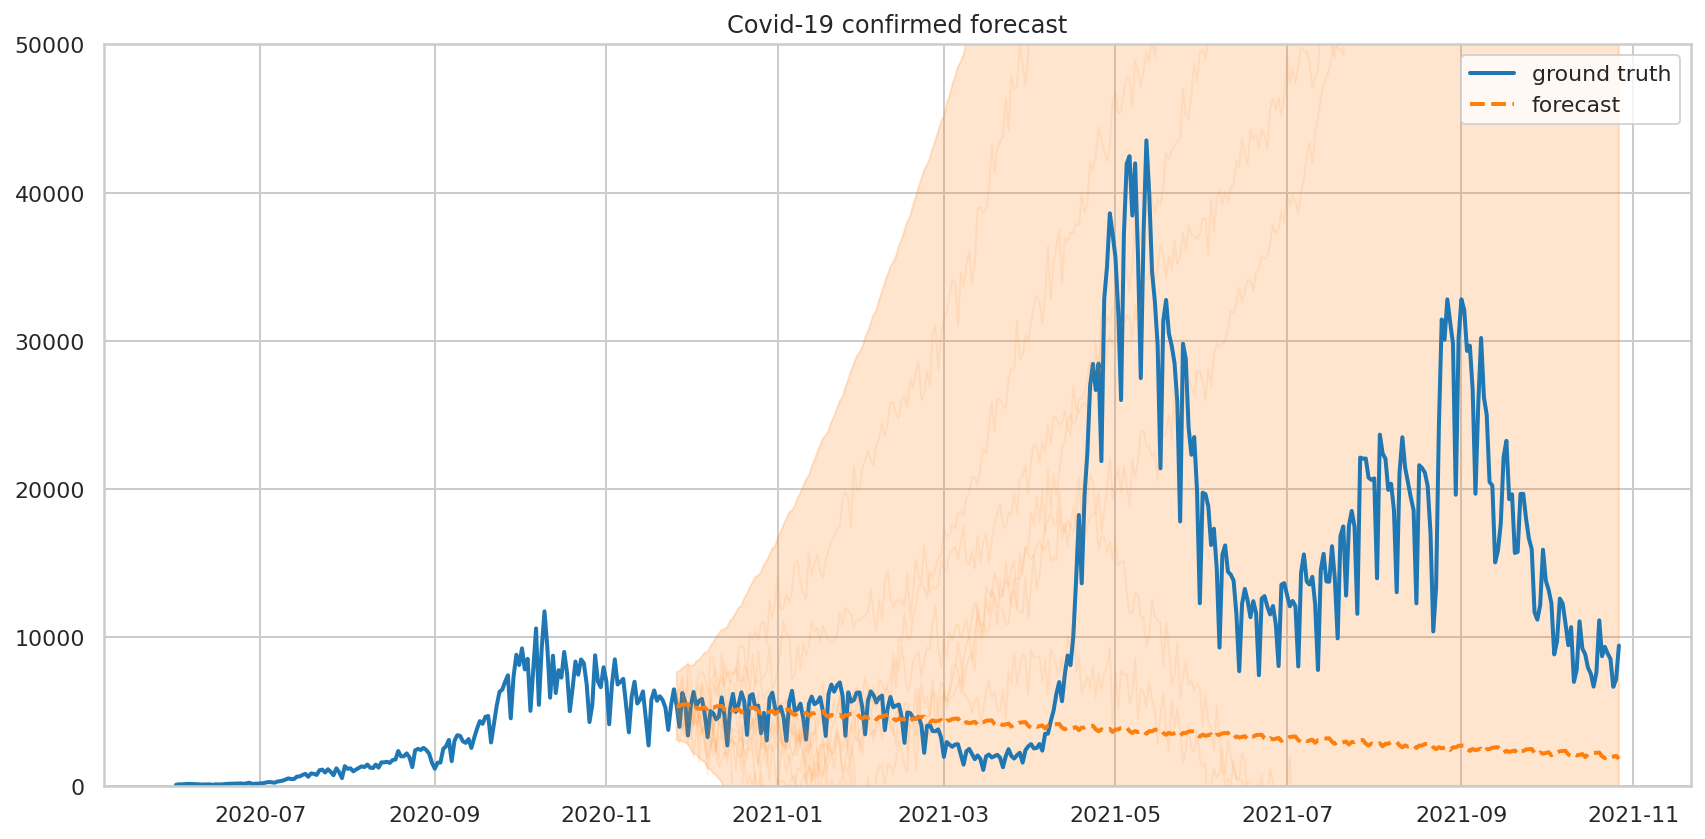

In [28]:
fig, ax = plot_forecast(a, b,
                        confirmed_forecast_mean,
                        confirmed_forecast_scale,
                        confirmed_forecast_samples,
                        title="Covid-19 confirmed forecast"#,
                        #x_locator=confirmed_loc, x_formatter=confirmed_fmt)
)
ax.set_ylim([0, 50000])
fig.tight_layout()

# Visualize the decomposition

In [ ]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    confirmed_model,
    observed_time_series=confirmed_training_data,
    parameter_samples=q_samples_confirmed_)

forecast_component_dists = sts.decompose_forecast_by_component(
    confirmed_model,
    forecast_dist=confirmed_forecast_dist,
    parameter_samples=q_samples_confirmed_)

In [ ]:
confirmed_component_means_, confirmed_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()})

(
    confirmed_forecast_component_means_,
    confirmed_forecast_component_stddevs_
) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )

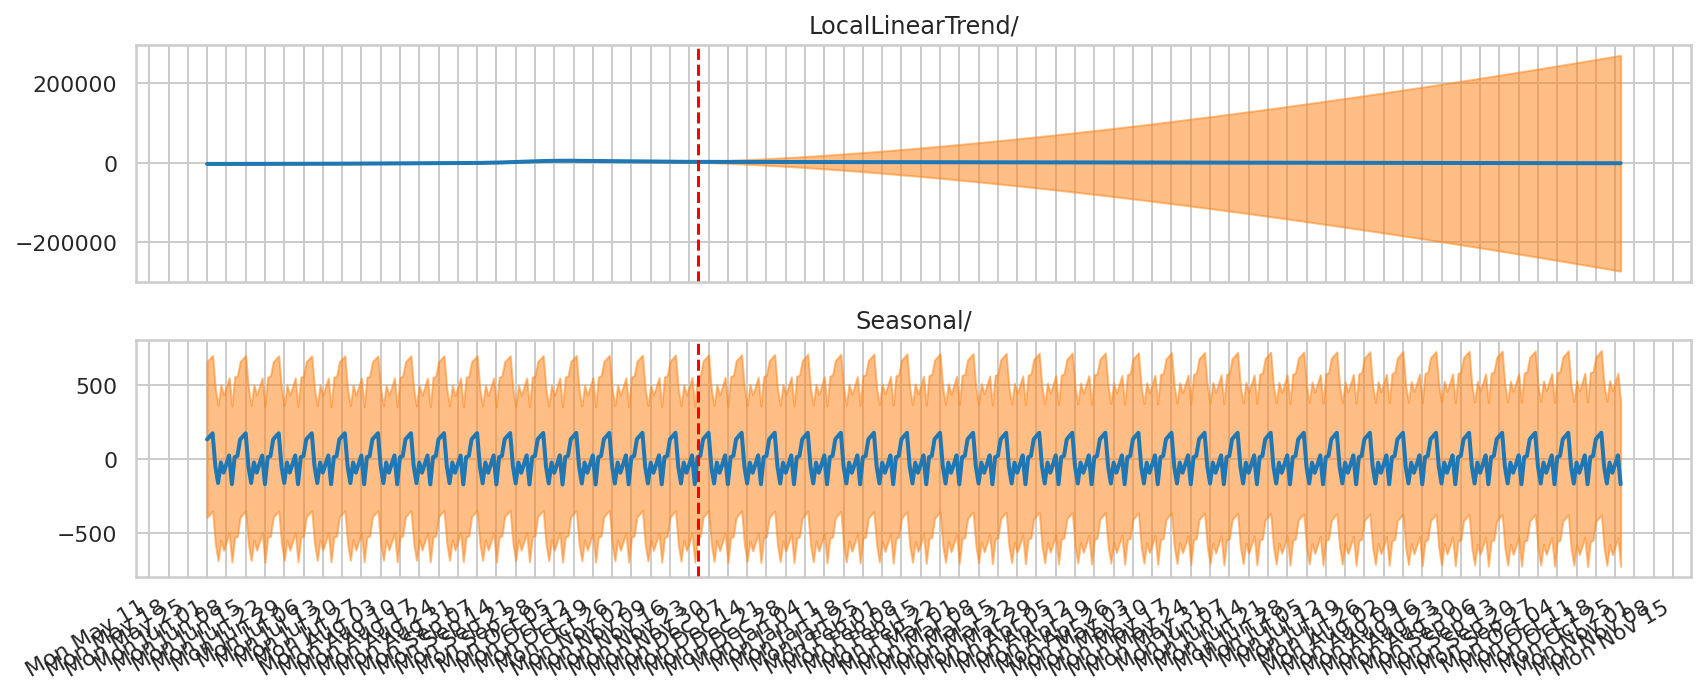

In [ ]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in confirmed_component_means_.keys():
  component_with_forecast_means_[k] = np.concatenate([
      confirmed_component_means_[k],
      confirmed_forecast_component_means_[k]], axis=-1)
  component_with_forecast_stddevs_[k] = np.concatenate([
      confirmed_component_stddevs_[k],
      confirmed_forecast_component_stddevs_[k]], axis=-1)


fig, axes = plot_components(
  df.index,
  component_with_forecast_means_,
  component_with_forecast_stddevs_,
  x_locator=confirmed_loc, x_formatter=confirmed_fmt)
for ax in axes.values():
  ax.axvline(df.index[-num_forecast_steps], linestyle="--", color='red')

In [ ]:
confirmed_one_step_dist = sts.one_step_predictive(
    confirmed_model,
    observed_time_series=df['Confirmed'],
    parameter_samples=q_samples_confirmed_)

confirmed_one_step_mean, confirmed_one_step_scale = (
    confirmed_one_step_dist.mean().numpy(), confirmed_one_step_dist.stddev().numpy())

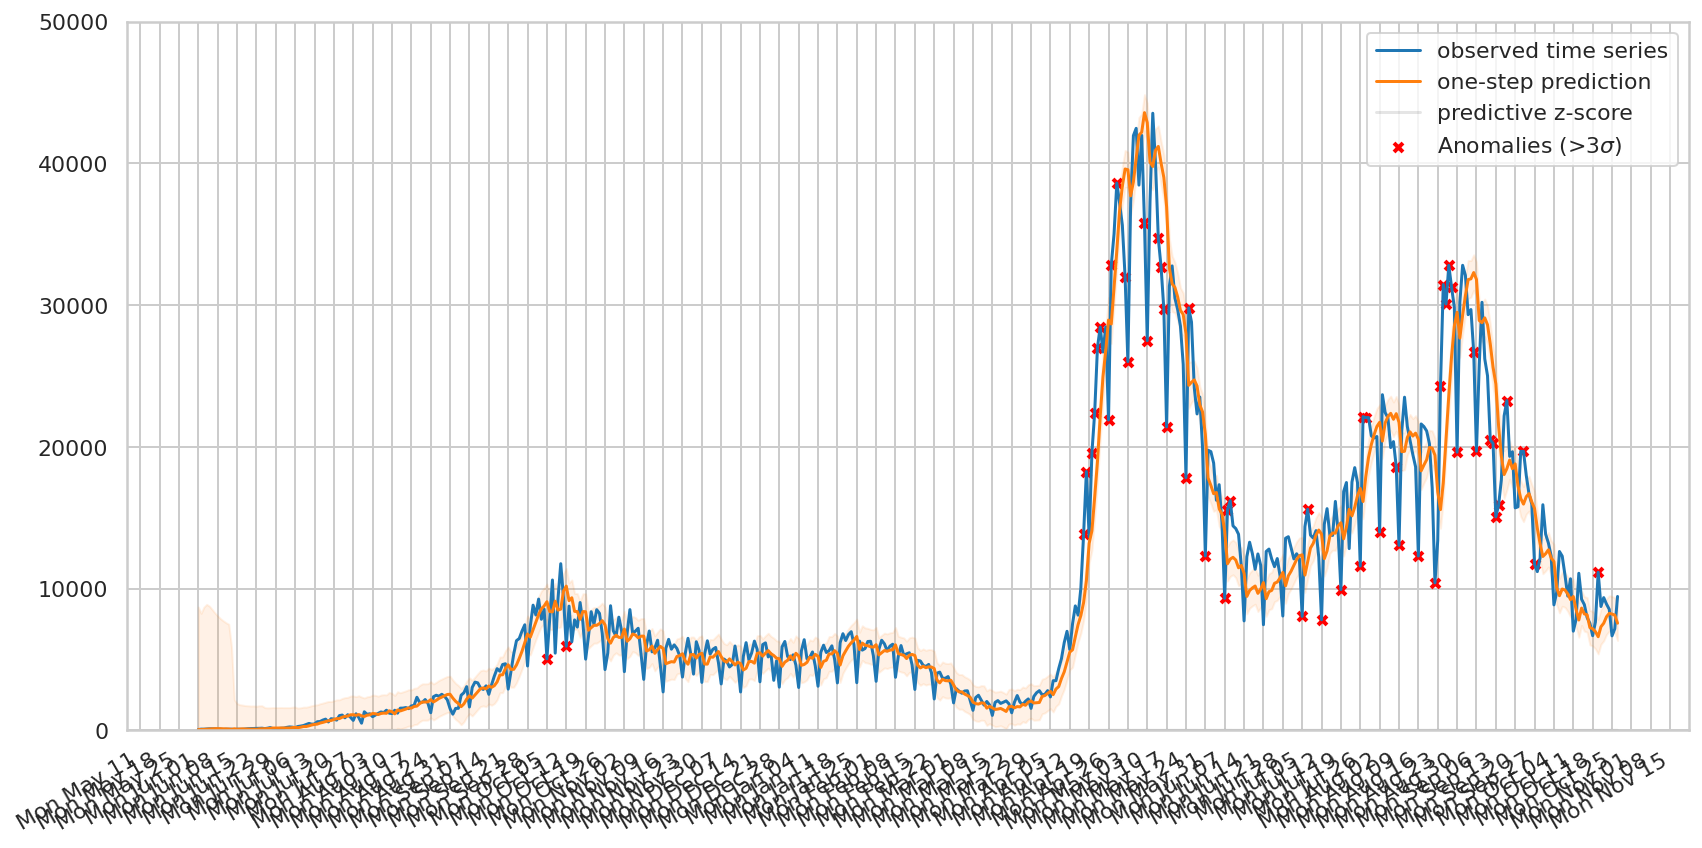

In [ ]:
fig, ax = plot_one_step_predictive(
    df.index, df['Confirmed'],
    confirmed_one_step_mean, confirmed_one_step_scale,
    x_locator=confirmed_loc, x_formatter=confirmed_fmt)
ax.set_ylim(0, 50000)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((df['Confirmed'] - confirmed_one_step_mean) /
                 confirmed_one_step_scale)
anomalies = zscores > 3.0
ax.scatter(df.index[anomalies],
           df['Confirmed'][anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>3$\sigma$)")
ax.plot(df.index, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()